In [1]:
# restart the notebook 
%load_ext autoreload
%autoreload 2

In [2]:
from barcode_generator import Barcode

Barcode()

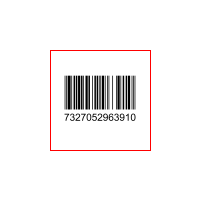

In [3]:
from overlay import Overlay
import random

class BarcodeOverlayGenerator:
    def __init__(self, min_width, max_width, min_height, max_height, min_rotation=-160, max_rotation=160, modification_pct=40):
        self.min_width = min_width
        self.max_width = max_width
        self.min_height = min_height
        self.max_height = max_height
        self.min_rotation = min_rotation
        self.max_rotation = max_rotation
        self.modification_pct = modification_pct

    def __call__(self):
        overlay = Overlay(Barcode().image(width=random.randint(self.min_width, self.max_width),
                                          height=random.randint(self.min_height, self.max_height)))

        if random.randint(0, 100) < self.modification_pct:
            overlay.rotate(random.randint(self.min_rotation, self.max_rotation))

        return overlay

class ProductImageGenerator:
    def __init__(self, images):
        self.images = images

    def __call__(self):
        return random.choice(self.images)


BarcodeOverlayGenerator(100, 100, 100, 100)().show()

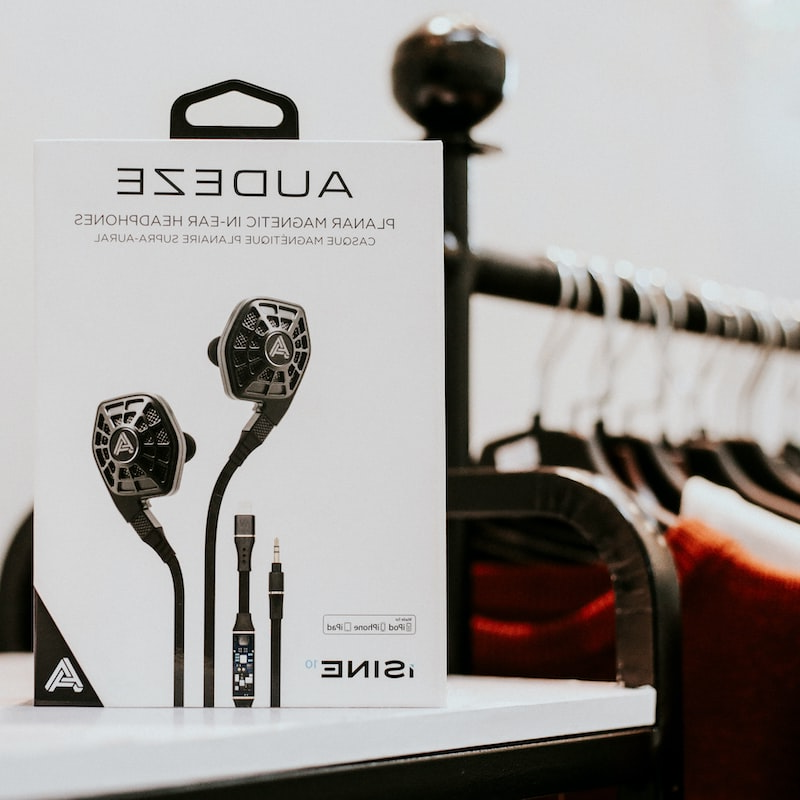

In [4]:
from background import Background

class BackgroundGenerator:
    def __init__(self, width=800, height=800, rotate=False, flip=True, modification_pct=40):
        self.width = width
        self.height = height
        self.rotate = rotate
        self.flip = flip
        self.modification_pct = modification_pct

    def __iter__(self):
        return self

    def __next__(self):
        return self()

    def __call__(self):
        return Background(self.width, self.height, self.rotate, self.flip, self.modification_pct).image

for image in BackgroundGenerator():
    break

image

In [5]:
import os
import multiprocessing as mp
import json
from functools import partial
from contextlib import closing
from pathos.multiprocessing import ProcessingPool as Pool
import time

# Record the start time
start_time = time.time()

# Your code here


class ImageSegmentationGenerator:
    def __init__(self, background_generator, overlay_generator,  min_overlays, max_overlays):
        self.overlays = overlay_generator
        self.backgrounds = background_generator
        self.min_overlays = min_overlays
        self.max_overlays = max_overlays

    @staticmethod
    def __generate__(amount, folder, gen_background, gen_overlay, min_overlays, max_overlays, timeout):
        import concurrent.futures
        import uuid
        import os

        # Load all the background asynchronously from the web
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            backgrounds = [executor.submit(lambda: gen_background()) for _ in range(amount)]
            try:
                # Wait for each background image to finish loading from the web
                for future in concurrent.futures.as_completed(backgrounds, timeout=timeout):
                    image = future.result()
                    image_id = uuid.uuid4()
                    image_path =  os.path.join(folder, "images", f"{image_id}.png")
                    meta_path =  os.path.join(folder, "labels", f"{image_id}.json")

                    overlays = []
                    # Generate a random amount of barcodes
                    for _ in range(random.randint(min_overlays, max_overlays)):
                        # Try to place 10 barcodes before giving up
                        for _ in range(10):
                            overlay: Overlay = gen_overlay()
                            found_coords = overlay.position(image, overlays)
                            if found_coords is None:
                                continue

                            x, y = found_coords
                            image = overlay.insert(image, x, y)
                            overlays.append(overlay)
                            break

                    image.save(image_path)
                    json.dump([overlay.dict() for overlay in overlays], open(meta_path, "w"))
            except TimeoutError:
                pass

    def generate(self, folder, amount):
        for child_folder in ["images", "labels"]:
            if not os.path.exists(os.path.join(folder, child_folder)):
                os.makedirs(os.path.join(folder, child_folder))

        self.__generate__(amount, folder,
                          gen_background=self.backgrounds,
                          gen_overlay=self.overlays,
                          min_overlays=self.min_overlays,
                          max_overlays=self.max_overlays,
                          timeout=20)

    def __call__(self, folder, image_amount, timeout=30):
        for child_folder in ["images", "labels"]:
            if not os.path.exists(os.path.join(folder, child_folder)):
                os.makedirs(os.path.join(folder, child_folder))

        num_workers = mp.cpu_count()
        with Pool(num_workers) as pool:
            images_pr_process = image_amount // num_workers

            job = partial(self.__generate__,
                          folder=folder,
                          gen_background=self.backgrounds,
                          gen_overlay=self.overlays,
                          min_overlays=self.min_overlays,
                          max_overlays=self.max_overlays,
                          timeout=timeout)

            pool.map(job, [images_pr_process for _ in range(num_workers)])


DSGen = ImageSegmentationGenerator(background_generator=BackgroundGenerator(),
                                   overlay_generator=BarcodeOverlayGenerator(50, 100, 30, 80),
                                   min_overlays=5,
                                   max_overlays=30)

DSGen("data", image_amount=700, timeout=100)

# Record the end time
end_time = time.time()

# Print the execution time in seconds
print(f"Execution time: {end_time - start_time} seconds")


Execution time: 46.73833894729614 seconds


RED IS BOUNDING BOX, IF NOT PRESENT IT IS THE SAME AS GREEN
GREEN IS CORNER OF BARCODE


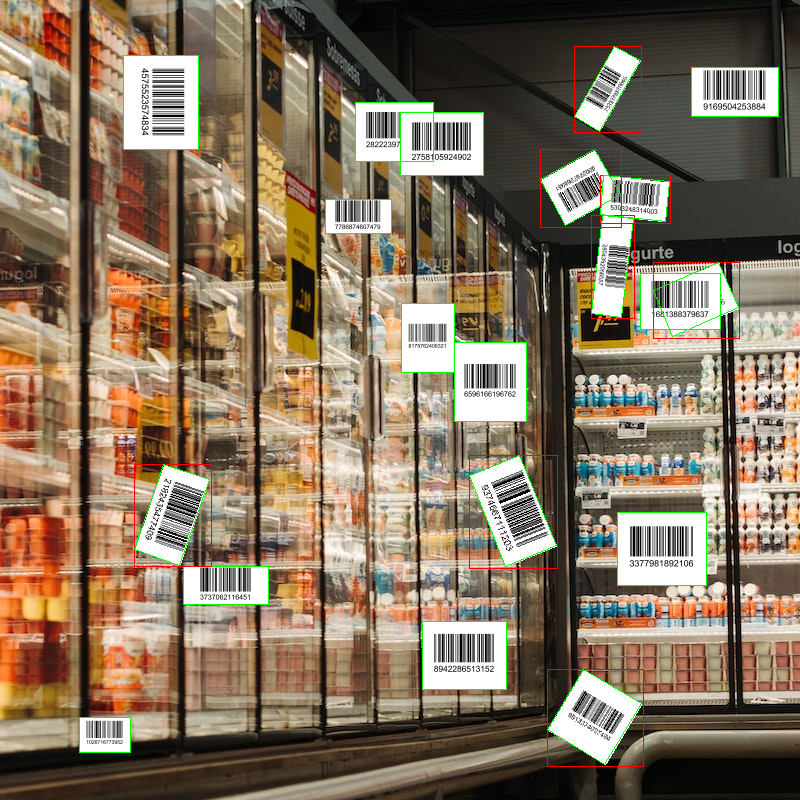

In [18]:
from glob import glob
import os
import json
from PIL import Image, ImageDraw
from IPython.display import display

image_path = random.choice(glob("data/images/*.png"))
ID = image_path.split(os.sep)[-1].split(".")[0]
label_path = f"data/labels/{ID}.json"

to_tuple = lambda arr: tuple([tuple(x) for x in arr])

with Image.open(image_path) as image:
    for label in json.load(open(label_path)):
        draw = ImageDraw.Draw(image)
        draw.polygon(to_tuple(label["bbox"]["corners"]), outline=(255, 0, 0))
        draw.polygon(to_tuple(label["corners"]["corners"]), outline=(0, 255, 0))

    print("RED IS BOUNDING BOX, IF NOT PRESENT IT IS THE SAME AS GREEN")
    print("GREEN IS CORNER OF BARCODE")
    display(image)

